# Introduction
In this project, I will focus on *Topic Modeling* and *Text Clustering*. When I began exploring about NLP, these two terms seemed similar to me. However, I figured out that they are completely different. Therefore, I will apply  two techniques on dataset *Spotify million songs* from Kaggle. This dataset can be found here:https://www.kaggle.com/datasets/notshrirang/spotify-million-song-dataset. The dataset contains more than 50000 song with four features: the artist name, the song's name, the link  and the lyrics of that song. 

The main purpose of my project is to define the song's genre based on their lyrics. This is the unsupervised learning task, since we do not know anything about the type of song. Hence, my idea is to apply machine learning techniques to assign each song to different groups that contain the similar song. To do this, I use two methods: *K-means* and *LDA topic modeling* in the project. Before applying the machine learning methods, we need to convert the lyric text into  numeric data. First of all, the most important step is text mining, where we clean the lyric text.

In [2]:
#Import library
import pandas as pd
import numpy as np
import time
# For plotting
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.io as plt_io
import plotly.graph_objects as go
#from bokeh.models import Label
#from bokeh.plotting import figure, output_file, show
from mpl_toolkits.mplot3d import Axes3D
import plotly.express as px
#Word processing
import re
import contractions
from nltk.tokenize import word_tokenize,sent_tokenize
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
from nltk.corpus import stopwords
from itertools import groupby
import spacy
#from spacy.cli.download import download
#download(model="en_core_web_sm")

In [3]:
df=pd.read_csv("D:\project\spotify_millsongdata.csv")

Let's take a lookt at our dataset. One thing to notice is the lyrics of the song in our dataset is not the full lyric.

In [4]:
df.head()

artist                   song                                        link  \
0   ABBA  Ahe's My Kind Of Girl  /a/abba/ahes+my+kind+of+girl_20598417.html   
1   ABBA       Andante, Andante       /a/abba/andante+andante_20002708.html   
2   ABBA         As Good As New        /a/abba/as+good+as+new_20003033.html   
3   ABBA                   Bang                  /a/abba/bang_20598415.html   
4   ABBA       Bang-A-Boomerang      /a/abba/bang+a+boomerang_20002668.html   

                                                text  
0  Look at her face, it's a wonderful face  \r\nA...  
1  Take it easy with me, please  \r\nTouch me gen...  
2  I'll never know why I had to go  \r\nWhy I had...  
3  Making somebody happy is a question of give an...  
4  Making somebody happy is a question of give an...

We will check the duplicates and delete it.

In [5]:
#check duplicate
duplicate_reviews= df.text.duplicated().sum()

print("There are {} duplicated reviews in reviews" .format(duplicate_reviews))

text = df['text']
duplicated_review = df[text.isin(text[text.duplicated()])].sort_values("text")
duplicated_review.head()

#drop duplicate song text
df=df.drop_duplicates(subset='text')
df.shape

There are 156 duplicated reviews in reviews


(57494, 4)

Next step is to clean the lyric texts. In this part, I will convert every texts into lower case. After that, we deal with the contraction words. It means that we need to convert *he'll* into *he will*, or *I'd* into *I would*. Then I will remove every parentheses and words inside it because these words could be the noise in our text.

Moreover, we need to get rid of special characters such as *,/,\ in the lyric and remmove stopwords such as *the, a, an*.

Since we are working with the lyrics, there could be some noises like *yeah, yah, ohhh* that have no meaning. Therefore, we need to eliminate these noises out of the text. 

The last step is stemming. Here, I will use *WordNetLemmatize()* function for the project.



In [6]:
stop_words=set(stopwords.words("english"))
df.text=df.text.str.lower()

def contraction_word(text):
    expanded_word=[]
    for word in text.split():
        expanded_word.append(contractions.fix(word))
    expanded_text=' '.join(expanded_word)
    return expanded_text  

def remove_parentheses(text):
    return re.sub("\(.*?\)|\[.*?\]","",text)

def special_character(text):
    text= re.sub(r'\W'," ",text)
    return text

def remove_stopwords(text):
    token=word_tokenize(text)
    token=[token for token in token if token not in stop_words]
    text=" ".join(token)
    return text

def text_steam(text):
    lemmatizer = WordNetLemmatizer()
    text = [lemmatizer.lemmatize(token) for token in text.split()]
    text = [lemmatizer.lemmatize(token, "v") for token in text]
    
    text=' '.join(text)
    return text


remove_words={'ya','la','yeah','bang','yay','let','please','oh','ah','eh','uh','wow','ooh','aah','ahh','ehh','eeh','hey','ha','hah','haha','doo','na','nah','boo','ya','da','pa',
          'could','would','should','let','ta','taa','yea','etc','get','let','daa',"chorus",'x2','chorus repeat','verse'}
def remove_special_words(text):
    tokens=word_tokenize(text)
    tokens=[token for token in tokens if token not in remove_words]
    text=' '.join(tokens)
    text=re.sub(r'\bu\b'," ",text)
    return text


def clean_text(text):
    text=contraction_word(text)
    text=remove_parentheses(text)
    text=special_character(text)
    text=remove_stopwords(text)
    text=text_steam(text)
    text=remove_special_words(text)
    return text


    



df.text=df.text.apply(clean_text)

In [7]:
corpus_norm=[text for text in df.text]
corpus_token=[text.split() for text in df.text]

After cleaning our lyric text, we continue to identify phrases (bigrams, trigrams) in our text. 

For example, we have the sentence: "A little boy always dream about traveling to New York". So usually, when we tokenize this text, it could become [a,little,boy,always,dream,about,traveling,to,new,york] which does not make sense. Therefore, we will apply function *Phrases* from Gensim to identify the meaningful bigrams and trigrams. When we apply this technique, the text above will become in this way [a,little_boy,always,dream,about,traveling,to,new_york]

In [8]:
from gensim.models import Phrases

from gensim.models.phrases import Phraser


#to create the bigrams
bigram_model = Phrases(corpus_token, min_count=4, threshold=100)

bigram_sentence =[' '.join(bigram_model[sent]) for sent in corpus_token]
    #list_corpus.append(bigram_sentence)


bigram_token=[text.split() for text in bigram_sentence]

#To create the Trigram
trigram_model=Phrases(bigram_token,min_count=4,threshold=100)

trigram_sentence=[' '.join(trigram_model[sent]) for sent in bigram_token]

trigram_token=[text.split() for text in trigram_sentence]



In [10]:
import spacy
#from spacy.cli.download import download
#download(model="en_core_web_sm")
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

Next step, I will use *spacy* library to identify parts of speech, and we're going to keep only noun, adjective, verb and adverb.

In [11]:
import spacy
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(trigram_token, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

In one song, there will be some consecutive duplicated words like *I will love love love love you forever*. This is just the way to sing of the singer, so we can consider this as the noise in the lyric. Hence in this project, I will keep only one word of the consecutive duplicated words.

In [12]:
def remove_consecutive_duplicates(text):
        text = [i[0] for i in groupby(text)]
        return ' '.join(text)
        #return text

        
df['text']=[remove_consecutive_duplicates(i) for i in data_lemmatized]


We coud use the *Counter* to identify the most common words in the text lyric. The word *go* is the most used word, followed by *love*. 

In [34]:
def get_corpus(text):
    words=[]
    for i in text:
        for j in i.split():
            words.append(j.strip())
    return words
corpus=get_corpus(df.text)
from collections import Counter
corpus=Counter(corpus)
corpus.most_common(5)

[('go', 96008),
 ('love', 82789),
 ('know', 71461),
 ('want', 55077),
 ('come', 50328)]

In [15]:
token=[text.split(" ") for text in df.text]


# Clustering
We have finished cleaning the lyric text. In this part, we will implement word embedding technique and apply k-mean method to cluster the songs into different groups.

We apply FastText directly on our dataset, without the pre-trained model, with the vector size is 300. I also set up the window_context=6 and min_word_count=5. Moreover, sg=1 means the model will use the *skip-gram* instead of *BOW*. 

In [16]:
from gensim.models import FastText
# Set values for various parameters
window_context = 6  
min_word_count = 5 



model = FastText(token,
  vector_size=300,        # Word embeddings dimensionality
  window=window_context,    # Context window size
   min_count=min_word_count,                     # `1` for skip-gram; otherwise CBOW.
  seed = 42,
sg=1,
hs=1,
   workers=1)

In [17]:
#save the model
model.save("word2vec.model")

In [18]:
#Load the model 
model = FastText.load("word2vec.model")


We find some similar words to *music* like *bogey_music, radio, rhythm*. The results are not very bad.

In [36]:
model.wv.most_similar("music")

[('bogey_music', 0.5219899415969849),
 ('program_director_radio', 0.49591436982154846),
 ('music_bob_seg', 0.4915894567966461),
 ('steve_millikan_ray_boltz', 0.47947290539741516),
 ('juke_box', 0.47409114241600037),
 ('radio', 0.44658035039901733),
 ('rhythm', 0.44420912861824036),
 ('copyright_1986_nazareth_ltd', 0.44237765669822693),
 ('flavour_ant', 0.4343057870864868),
 ('musician', 0.43292999267578125)]

Since this is the word embedding technique, so each word is now converted into the 300-dimension vector. However, the problem of the FastText that we only have Word Embeddings but not Document Embeddings. Therefore, we need to find the average embeddings for the entire document.

In [20]:
def average_word_vectors(words,model,vocabulary,num_features):
    feature_vector=np.zeros((num_features,),dtype="float64")
    nwords=0
    
    for word in words:
        if word in vocabulary:
            nwords=nwords+1
            feature_vector=np.add(feature_vector,model.wv[word])
        if nwords:
            feature_vector=np.divide(feature_vector,nwords)
        return feature_vector
    

def averaged_word_vectorizer(corpus, model, num_features):
    vocabulary = set(model.wv.index_to_key)
    features = [
        average_word_vectors(tokenized_sentence, model, vocabulary,
                             num_features) for tokenized_sentence in corpus
    ]
    return np.array(features)

w2w_feature_array is our document embeddings, we can see that now each document has the 300-dimension vector representation.

In [21]:

w2v_feature_array = averaged_word_vectorizer(corpus=token,
                                             model=model,
                                             num_features=300)

pd.DataFrame(w2v_feature_array, index=corpus_norm)

0         1    \
look face wonderful face mean something special...  0.034352  0.153649   
take easy touch gently like summer even breeze ...  0.115042  0.093100   
never know go put lousy rotten show boy tough p... -0.012205  0.075812   
make somebody happy question give take learn sh... -0.015351  0.032007   
make somebody happy question give take learn sh... -0.015351  0.032007   
...                                                      ...       ...   
irie day come play angel fly devil die time han... -0.263960 -0.008496   
power worker power power worker need power powe... -0.143974  0.071521   
need something believe flashlight hall call day...  0.077085  0.105702   
northern star frighten go rest sleep still figh... -0.075655  0.031991   
come make home bite late hate make wait heart s... -0.006696  0.107189   

                                                         2         3    \
look face wonderful face mean something special...  0.192440 -0.126213   
take easy touch gently like summer even breeze ...  0.085830  0.128409   
never know go put lousy rotten show boy tough p...  0.158472 -0.060551   
make somebody happy question give take learn sh... -0.007196 -0.005226   
make somebody happy question give take learn sh... -0.007196 -0.005226   
...                                                      ...       ...   
irie day come play angel fly devil die time han...  0.034335  0.052676   
power worker power power worker need power powe... -0.034993 -0.011874   
need something believe flashlight hall call day...  0.148596 -0.112492   
northern star frighten go rest sleep still figh...  0.065976 -0.068906   
come make home bite late hate make wait heart s...  0.059320 -0.023658   

                                                         4         5    \
look face wonderful face mean something special... -0.064505  0.046495   
take easy touch gently like summer even breeze ...  0.007708  0.099423   
never know go put lousy rotten show boy tough p... -0.045679  0.037639   
make somebody happy question give take learn sh...  0.109671  0.042186   
make somebody happy question give take learn sh...  0.109671  0.042186   
...                                                      ...       ...   
irie day come play angel fly devil die time han...  0.157133 -0.002082   
power worker power power worker need power powe... -0.063665  0.073647   
need something believe flashlight hall call day... -0.089139  0.061580   
northern star frighten go rest sleep still figh...  0.008359  0.041798   
come make home bite late hate make wait heart s...  0.060995  0.169402   

                                                         6         7    \
look face wonderful face mean something special... -0.120249  0.057793   
take easy touch gently like summer even breeze ...  0.038720  0.031271   
never know go put lousy rotten show boy tough p... -0.005187  0.097699   
make somebody happy question give take learn sh... -0.060295  0.080180   
make somebody happy question give take learn sh... -0.060295  0.080180   
...                                                      ...       ...   
irie day come play angel fly devil die time han...  0.039795  0.034296   
power worker power power worker need power powe... -0.129637  0.064268   
need something believe flashlight hall call day... -0.000713  0.044570   
northern star frighten go rest sleep still figh... -0.029890  0.038259   
come make home bite late hate make wait heart s... -0.021130  0.115570   

                                                         8         9    ...  \
look face wonderful face mean something special...  0.016852  0.023539  ...   
take easy touch gently like summer even breeze ...  0.163913  0.092323  ...   
never know go put lousy rotten show boy tough p...  0.131612  0.268236  ...   
make somebody happy question give take learn sh...  0.104401  0.255296  ...   
make somebody happy question give take learn sh...  0.104401  0.255296  ...   
...                        

From here, we can apply k-means for our text dataset. However, before moving to that part, we still have some steps to do. First, we use *StandardScaler* to standardize dataset by removing the mean and scaling to unit variance. Then applying PCA to reduce the dimensionality of the dataset.

In [22]:
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler().fit(w2v_feature_array)
w2v_feature_array_scale=scaler.transform(w2v_feature_array)

We use PCA to reduce the dimensionality of the document embeddings vector. Here, the dimension was reduced from 300 to 210 but it still can explain 90% variance of the original data.

In [23]:
#apply PCA to reduce dimension
from sklearn.decomposition import PCA
pca_90=PCA(0.90,random_state=42)
pca_90=pca_90.fit_transform(w2v_feature_array_scale)
pca_90.shape

(57494, 210)

In the clustering problem, the most difficult thing is to find the optimal number of cluster. We do not have the exact result for the unsupervised learning task. However, we still have some methods to guess the optimal number of cluster and we will use the *Elbow method* for our project to find the number *k* clusters.

c:\Users\Quoc Nguyen\anaconda3\envs\tensorflow\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Quoc Nguyen\anaconda3\envs\tensorflow\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Quoc Nguyen\anaconda3\envs\tensorflow\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Quoc Nguyen\anaconda3\envs\tensorflow\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppre

[]

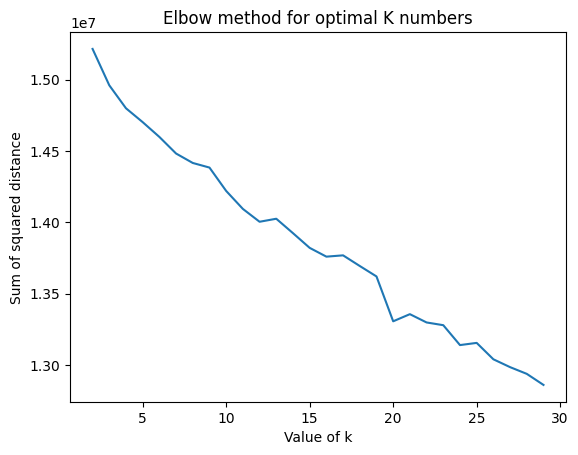

In [24]:
from sklearn.cluster import KMeans
sum_distance=[]
K = range(2,30)
for i in K:
    kmeans=KMeans(n_clusters=i,random_state=42).fit(pca_90)
    sum_distance.append(kmeans.inertia_)

#plot elbow
plt.plot(K,sum_distance)
plt.xlabel("Value of k")
plt.ylabel("Sum of squared distance")
plt.title("Elbow method for optimal K numbers")
plt.plot()

From the graph, it's hard to detect to Elbow point. Therefore, I will choose randomly 9 clusters for this problem.

In [40]:
#Choose k =10
kmeans=KMeans(n_clusters=9,random_state=43)
kmeans.fit(pca_90)
df['labels']=kmeans.labels_

c:\Users\Quoc Nguyen\anaconda3\envs\tensorflow\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



The result seemed not very good since nearly a half of the song in dataset was assigned into cluster 7. Or maybe because the majority song in our dataset is the same genre.

In [42]:
print(df.labels.value_counts())


labels
7    20788
6     9930
5     8566
4     5795
0     4794
8     3784
2     2779
3      709
1      349
Name: count, dtype: int64


We use PCA to plot our dataset in the two-dimension and three-dimension.

Duration: 0.4044156074523926 seconds


Text(0.5, 1.0, 'Plot of 2-dimension PCA ')

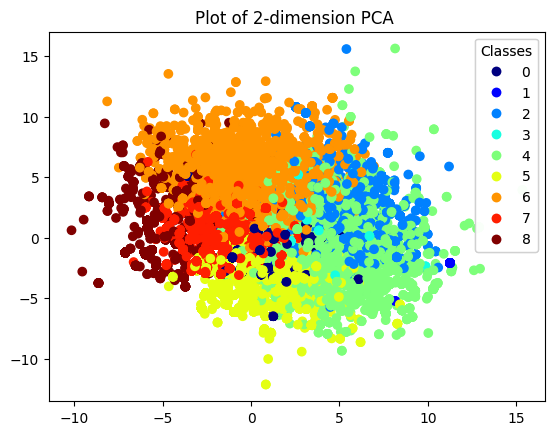

In [47]:
from sklearn.decomposition import PCA
#Labels
y=df['labels']
#PCA 
start = time.time()
pca = PCA(n_components=3)
principalComponents = pca.fit_transform(w2v_feature_array_scale)
print('Duration: {} seconds'.format(time.time() - start))

#plot PCA 2D
fig, ax = plt.subplots()
scatter=ax.scatter(principalComponents[:,0],principalComponents[:,1],c=y,cmap='jet')

legend1 = ax.legend(*scatter.legend_elements(), title="Classes")
ax.add_artist(legend1)
ax.set_title("Plot of 2-dimension PCA ")

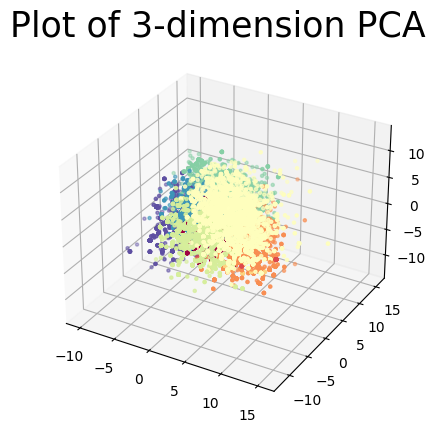

In [53]:

#PLOT PCA3
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(principalComponents[:, 0], principalComponents[:, 1],principalComponents[:,2],s=5, c=y, cmap='Spectral')

plt.title('Plot of 3-dimension PCA ', fontsize=25);
plt.show()

We can see that there are some good separation between each cluster, but still have many overlappings.

Next, we visualize dataset by using Linear Discriminant Analysis.

Text(0.5, 1.0, 'Plot of 2-dimensions LDA')

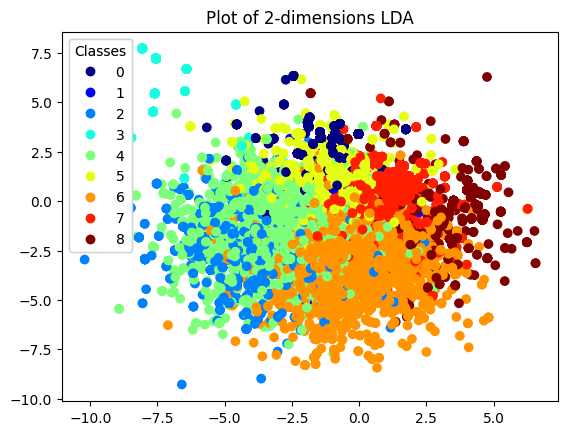

In [45]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

x_lda=LinearDiscriminantAnalysis(n_components=3).fit_transform(pca_90,y)


fig, ax = plt.subplots()
scatter=ax.scatter(x_lda[:,0],x_lda[:,1],c=y,cmap='jet')

legend1 = ax.legend(*scatter.legend_elements(), title="Classes")
ax.add_artist(legend1)
ax.set_title("Plot of 2-dimensions LDA")


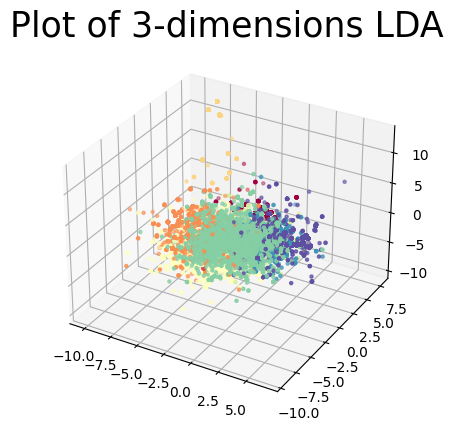

In [52]:

#PLOT LDA 3-dimensions
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x_lda[:, 0], x_lda[:, 1],x_lda[:,2],s=5, c=y, cmap='Spectral')

plt.title('Plot of 3-dimensions LDA', fontsize=25);
plt.show()

The plots are a little bit better than PCA but it still many overlappings. 

Next, T-SNE will be used for the dimensionality reduction and plot it into 2-dimension, 3-dimension.

Duration: 319.68817949295044 seconds


Text(0.5, 1.0, 'Plot of 2-dimensions LDA')

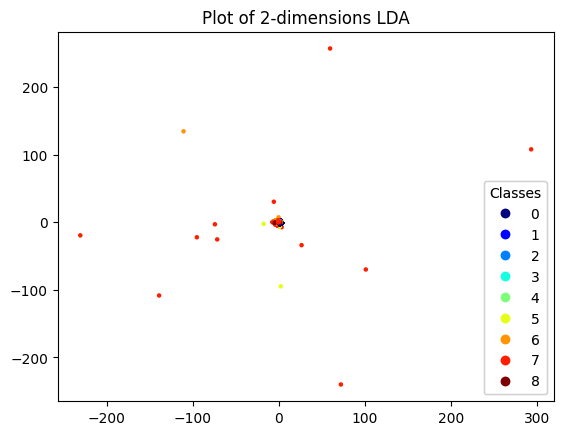

In [51]:
#TSNE
from sklearn.manifold import TSNE
start = time.time()
#PCA with n_components 30
pca_100 = PCA(n_components=100)
pca_100 = pca_100.fit_transform(w2v_feature_array_scale)
tsne = TSNE(random_state = 42, n_components=3,verbose=0, perplexity=250, n_iter=250).fit_transform(pca_100)
print('Duration: {} seconds'.format(time.time() - start))


fig, ax = plt.subplots()
scatter=ax.scatter(tsne[:,0],tsne[:,1],s=5,c=y,cmap='jet')

legend1 = ax.legend(*scatter.legend_elements(), title="Classes")
ax.add_artist(legend1)
ax.set_title("Plot of 2-dimensions T-SNE")

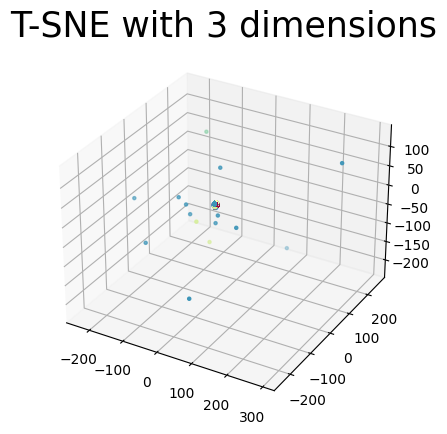

In [54]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(tsne[:, 0], tsne[:, 1],tsne[:,2],s=5, c=y, cmap='Spectral')
plt.title('T-SNE with 3 dimensions', fontsize=25);
plt.show()


The result definitely is not expected.

By applying three different techiniques, we could see that our dataset with 9 clusters is not a good result. The problem could come from the lyric dataset, since these lyrics are not the full lyrics. Moreover, each song could contain many same words so it makes the document embedding vector has the near value. That's why the half of the song in the dataset was assigned in one cluster.

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
def get_top_text_ngrams(corpus, n, g):
    vec = CountVectorizer(ngram_range=(g, g)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

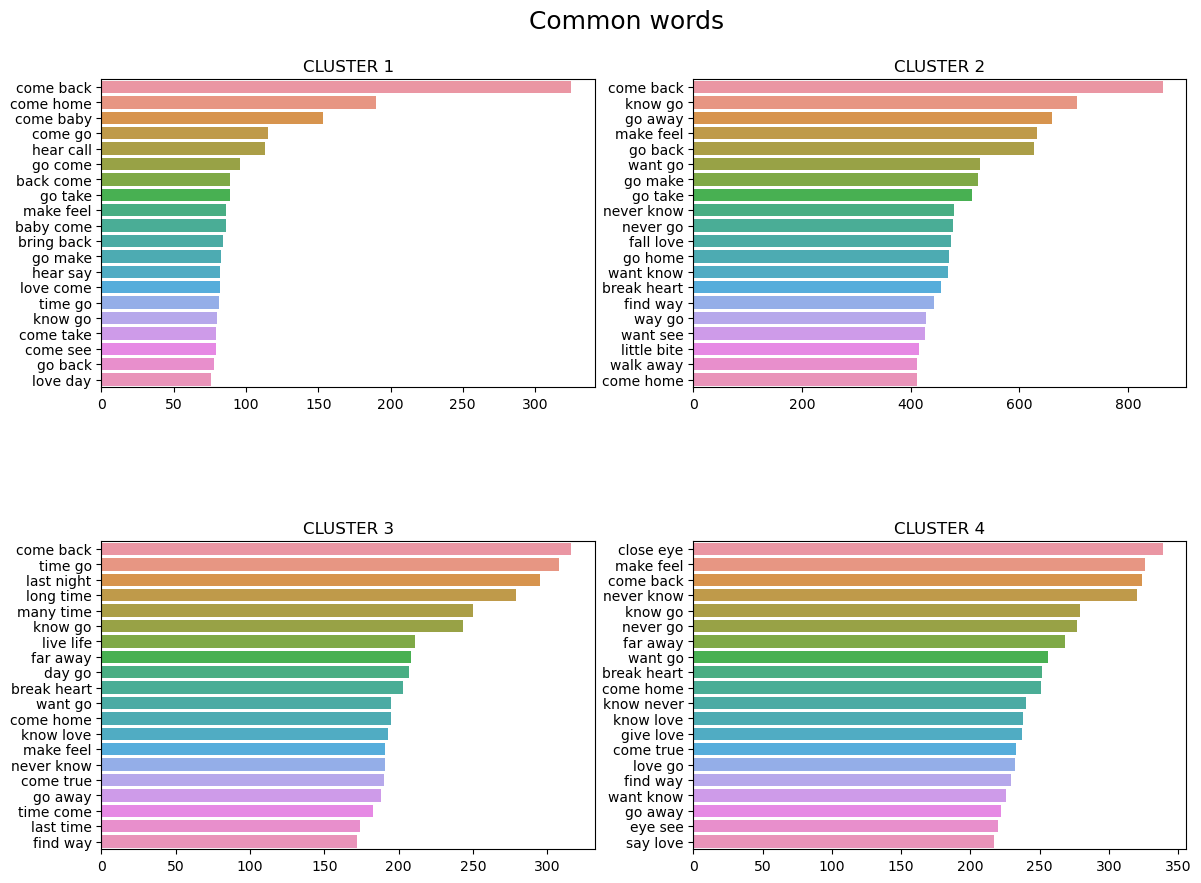

In [ ]:
# define subplot grid
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(14, 10))
plt.subplots_adjust(hspace=0.5)
fig.suptitle("Common words", fontsize=18, y=0.95)

cluster=[1,2,3,4]
no_words=20
ngram=2
# loop through tickers and axes
for i, ax in zip(cluster, axs.ravel()):
    text=df[df.labels==i]['text']
    most_common_word=get_top_text_ngrams(text,no_words,ngram)
    most_common_word=dict(most_common_word)
    common=pd.DataFrame(columns=['Common_words','count'])
    common['Common_words']=list(most_common_word.keys())
    common['count']=list(most_common_word.values())
    sns.barplot(data=common,y="Common_words",x="count",ax=ax)
    
    # chart formatting
    ax.set_title("Cluster {}".format(str(i)).upper())
    ax.set(xlabel=None)
    ax.set(ylabel=None)
plt.show()

The plots above show the 10 common bigrams in the four clusters. We hardly define any different between four groups, it shows that four clusters contain all the love song. The bigram *come back* is the most common bigram in three cluster. This explains the overlappings that we saw in the previous plots.

We can find the song that represents for each cluster by finding the song which is nearest to the cluster centroid.

In [ ]:
from scipy.spatial.distance import euclidean
for i in range(kmeans.n_clusters):
    distance=[]
    cluster_index=np.where(kmeans.labels_==i)[0]
    cluster_center=kmeans.cluster_centers_[i]
    min_idx = np.argmin([euclidean(pca_90[idx], cluster_center) for idx in cluster_index])
    print("Text represents for cluster",i,"is:\n",df.text[min_idx],"\n")
    
    
    
    
    
    
    
    

Text represents for cluster 0 is:
 darkness dawn swirl storm roll punch hope go leave light mile home swirl swim roll thunder light leave light leave light leave light darkness dawn darkness dawn leave light leave light 

Text represents for cluster 1 is:
 waitin baby sit alone feel cold chill bone never think leave know true baby sittin alone feel cold chill bone never think leave know true little memory thing use 

Text represents for cluster 2 is:
 lie head chest hear beat heart keep apart touch lip close eye see fingertip thing know crazy bout kiss fire burn point return kiss fire sweet devotion catch landslide emotion share love compare rid high sky fire kiss fire kiss fire sleep side feel safe know belong still make scar love strong lose babe never see beg kiss fire burn point return kiss fire sweet devotion catch landslide emotion share love compare rid high sky fire kiss fire kiss fire kiss fire burn point return kiss fire sweet devotion catch land slide emotion kiss fire burn 

In [ ]:
for i in sorted(list(dict.fromkeys(df['labels']))):
    a=df[df['labels']==i].groupby(['artist'])['artist'].count().sort_values(ascending=False).head(3)
    print("The most frequency artist in the cluster {} is:\n".format(i),a)
    print("\n")

The most frequency artist in the cluster 0 is:
 artist
Lil Wayne        35
Fabolous         33
Conway Twitty    30
Name: artist, dtype: int64


The most frequency artist in the cluster 1 is:
 artist
Christmas Songs    19
Neil Young         15
Hillsong           14
Name: artist, dtype: int64


The most frequency artist in the cluster 2 is:
 artist
Iggy Pop           65
John Mellencamp    63
Marilyn Manson     62
Name: artist, dtype: int64


The most frequency artist in the cluster 3 is:
 artist
John Denver      26
Glen Campbell    25
Donna Summer     25
Name: artist, dtype: int64


The most frequency artist in the cluster 4 is:
 artist
Slayer             50
Rush               48
Hillsong United    38
Name: artist, dtype: int64


The most frequency artist in the cluster 5 is:
 artist
Kiss               74
Luther Vandross    72
Backstreet Boys    72
Name: artist, dtype: int64


The most frequency artist in the cluster 6 is:
 artist
Christmas Songs     37
Michael W. Smith    34
Gordon Ligh

In the cluster 0, Lil Wayne and Fabolous are the two artists that have most song in the cluster 0. Therefore, the songs in cluster 0 could be the rap song.

# Topic modeling
It can be seen that text clustering by k-means does not give us the good result. Therefore, in the next section, I will apply Latent Dirichlet Allocation (LDA) to defind the topic in each document. Topic modeling and text clustering are all the unsupervised learning technique but the ways they work are different. 

Clustering seeks to split documents into a certain number of groups based on a similarity metric. Based on the document embeddings vectors, k-means technique assigns each document to the cluster that has the nearest centroid to that document. Therefore, clustering ignores the context of the document during partitioning.

 While, Topic modeling seeks to discover latent topics that describe the collection of documents. The purpose of topic modeling methods is to discover the latent themes (topics) assumed to have generated the documents of a corpus. Topic modeling methods are built on the distributional hypothesis, suggesting that similar words occur in similar contexts. To this end, they assume a generative process (a sequence of steps), which is a set of assumptions that describe how the documents are generated. Given the assumptions of the generative process, inference is done, which results in learning the latent variables of the model. For instance, for Latent Dirichlet Allocation, this is the per-topic document distributions and the per-word document distributions. In this sense, a document can be represented by its per-topic distribution (doc1
 = 0.7×Music + 0.3xCinema). This later can be seen as a soft clustering approach, i.e., doc1
 belongs 70% in cluster Music and 30% in Cinema. But topic models are not solely clustering methods, as can also been used for understanding, exploring, visualizing a collection.

LDA technique is supported by two libraries: gensim and sklearn. We will explore LDA by Gensim library first and then LDA by sklearn.


In [55]:
### LDA Model

import gensim.corpora as corpora

#Create Dictionary
id2word=corpora.Dictionary(token)
id2word.filter_extremes(no_below=7, no_above=0.8)
#Create Corpus
texts=token

#Term Document Frequency

corpus=[id2word.doc2bow(text) for text in texts]

corpus[:1]

[[(0, 2),
  (1, 2),
  (2, 4),
  (3, 2),
  (4, 2),
  (5, 1),
  (6, 2),
  (7, 4),
  (8, 2),
  (9, 1),
  (10, 1),
  (11, 1),
  (12, 4),
  (13, 2),
  (14, 2),
  (15, 1),
  (16, 2),
  (17, 1),
  (18, 2),
  (19, 1),
  (20, 1),
  (21, 1),
  (22, 1),
  (23, 1),
  (24, 1),
  (25, 1),
  (26, 1),
  (27, 2),
  (28, 1),
  (29, 1)]]

Here, we filter out the words that appear less than 7 times and the words that appear in more than 80% of corpus.

We will choose 9 topics for our LDA model.

In [56]:
import gensim
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=9, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=5,
                                           alpha='auto',
                                           per_word_topics=True)

In [ ]:
lda_model.save("D:\\project/model_lda_100.model")

In [ ]:
# Load model
from gensim.models.ldamodel import LdaModel
lda = LdaModel.load("D:\\project/model_lda_100.model")

In [57]:
from pprint import pprint

pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.137*"life" + 0.082*"live" + 0.050*"die" + 0.047*"people" + 0.045*"world" '
  '+ 0.044*"soul" + 0.037*"fight" + 0.026*"dead" + 0.024*"move" + '
  '0.021*"deep"'),
 (1,
  '0.207*"love" + 0.086*"baby" + 0.082*"heart" + 0.062*"give" + 0.053*"need" + '
  '0.051*"hold" + 0.030*"tonight" + 0.022*"break" + 0.021*"together" + '
  '0.021*"true"'),
 (2,
  '0.075*"man" + 0.048*"little" + 0.043*"call" + 0.031*"old" + 0.028*"money" + '
  '0.021*"woman" + 0.018*"drink" + 0.018*"work" + 0.018*"name" + '
  '0.016*"young"'),
 (3,
  '0.049*"see" + 0.033*"day" + 0.028*"eye" + 0.021*"dream" + 0.020*"fall" + '
  '0.019*"hand" + 0.017*"look" + 0.017*"stand" + 0.016*"face" + 0.015*"lie"'),
 (4,
  '0.067*"hear" + 0.065*"night" + 0.049*"light" + 0.032*"dance" + 0.031*"sing" '
  '+ 0.028*"burn" + 0.026*"song" + 0.026*"fire" + 0.019*"sound" + '
  '0.016*"wind"'),
 (5,
  '0.023*"child" + 0.023*"black" + 0.022*"year" + 0.019*"new" + 0.017*"grow" + '
  '0.013*"rise" + 0.012*"kid" + 0.012*"peace" + 0.012*"l

Each topic in topic modeling can be described by the probabilistic distribution of words. For example, Topic 1 contains '0.207*"love" + 0.086*"baby" + 0.082*"heart" + 0.062*"give" + 0.053*"need" + ''0.051*"hold" + 0.030*"tonight" + 0.022*"break" + 0.021*"together" + '
  '0.021*"true"'. It shows that word *love* appear the most in the topic 1, followed by word *baby*. Therefore, songs in this topic is the love song. 

In [58]:
from gensim.models.coherencemodel import CoherenceModel

# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=token, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -6.8165562382722955

Coherence Score:  0.40745386284773727


The higher the coherance score, the better the model. We can use this score to find the optimal number of topics.

In [61]:
# Plotting tools
#!pip install pyLDAvis

import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
8      0.221796  0.086490       1        1  29.251623
3      0.201588 -0.047042       2        1  16.273258
6      0.129978 -0.082833       3        1  12.186414
1      0.172896  0.099999       4        1   8.563244
7     -0.036005 -0.113267       5        1   8.093796
2     -0.178026  0.015417       6        1   7.582820
4     -0.139863 -0.218795       7        1   6.649976
5     -0.185661  0.374858       8        1   6.529630
0     -0.186704 -0.114828       9        1   4.869239, topic_info=        Term          Freq         Total Category  logprob  loglift
8         go  95826.000000  95826.000000  Default  30.0000  30.0000
82      love  73671.000000  73671.000000  Default  29.0000  29.0000
107     come  48239.000000  48239.000000  Default  28.0000  28.0000
56      take  42210.000000  42210.000000  Default  27.0000  27.0000
41      know  72273.000000  72273.000000  Default  26.0000  26.0000
...      ...           ...           ...      ...      ...      ...
30      body   2423.293136   4029.557148   Topic9  -4.4228   2.5137
1150    step   1782.930890   2504.840461   Topic9  -4.7297   2.6823
335   search   1707.586832   2365.007857   Topic9  -4.7729   2.6965
242    truth   2040.333416   3910.710068   Topic9  -4.5948   2.3716
436   become   1596.401556   2383.492764   Topic9  -4.8402   2.6214

[446 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
388       3  0.999604        ago
389       7  0.999685        air
155       9  0.999894      alive
157       2  0.146528      alone
157       3  0.768529      alone
...     ...       ...        ...
270       9  0.519446      world
414       1  0.000512       year
414       8  0.999308       year
538       3  0.999714  yesterday
306       6  0.999860      young

[627 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[9, 4, 7, 2, 8, 3, 5, 6, 1])

We can see the good separation between 9 topics here. However, there are also overlappings where the topic 4 was the subset of topic 1. 

In [ ]:
## Create the dominant topic dataframe
topics=list(lda_model.get_document_topics(corpus, minimum_probability=0))
dominant_topic=[]
perc_topic=[]
topic_key=[]
for i in  topics:
    dominant_topic.append(sorted(i, key=lambda x: x[1], reverse=True)[0][0]) #Find the dominant topic
    topic_key.append(list(w for w,_ in lda_model.show_topic(topicid=sorted(i, key=lambda x: x[1], reverse=True)[0][0],topn=10))) #Find the topic keywords
    
    perc_topic.append(sorted(i, key=lambda x: x[1], reverse=True)[0][1]) # Find the prob. of the dominant topic
topic_perc={'Topic':dominant_topic,'Percent':perc_topic,"Keywords":topic_key}

df_dominant_topc=pd.DataFrame(topic_perc)

contents = pd.Series(token)
df_dominant_topics = pd.concat([df_dominant_topc, contents], axis=1)
df_dominant_topics.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords','Text']


In topic modeling, each document can also described by the probabilistic distribution of topics. Here, we find the topic that contributed the most in each document and consider it as the dominant topic. For example, topic 8 contributed nearly a half of that lyric. which means topic 8 is the dominant topic of that song.

In [ ]:
df_dominant_topics

Dominant_Topic  Perc_Contribution  \
0                   8           0.491902   
1                   8           0.315180   
2                   8           0.501337   
3                   8           0.344450   
4                   8           0.344454   
...               ...                ...   
57489               8           0.304372   
57490               8           0.299005   
57491               6           0.254224   
57492               3           0.310660   
57493               8           0.460276   

                                          Topic_Keywords  \
0      [know, want, say, make, time, never, feel, way...   
1      [know, want, say, make, time, never, feel, way...   
2      [know, want, say, make, time, never, feel, way...   
3      [know, want, say, make, time, never, feel, way...   
4      [know, want, say, make, time, never, feel, way...   
...                                                  ...   
57489  [know, want, say, make, time, never, feel, way...   
57490  [know, want, say, make, time, never, feel, way...   
57491  [go, come, take, back, leave, away, long, run,...   
57492  [see, day, eye, dream, fall, hand, look, stand...   
57493  [know, want, say, make, time, never, feel, way...   

                                                    Text  
0      [look, face, wonderful, face, mean, special, l...  
1      [take, easy, touch, gently, summer, even, bree...  
2      [never, know, go, put, lousy, rotten, show, bo...  
3      [make, happy, question, give, take, learn, sho...  
4      [make, happy, question, give, take, learn, sho...  
...                                                  ...  
57489  [day, come, play, angel, fly, die, time, hand,...  
57490  [power, worker, power, worker, need, power, wo...  
57491  [need, believe, day, find, belong, wait, curb,...  
57492  [go, rest, sleep, still, fight, wait, breathe,...  
57493  [come, make, home, bite, late, hate, make, wai...  

[57494 rows x 4 columns]

In [ ]:
print(df_dominant_topics.Dominant_Topic.value_counts())

Dominant_Topic
8    37801
3    10427
6     2772
7     1798
1     1758
4     1215
2      877
5      622
0      224
Name: count, dtype: int64


The majority of the song was assigned into topic 8.

In [ ]:
new_song=["I'm beginning to feel like a Rap God, Rap God All my people from the front to the back nod, back nod Now who thinks their arms are long enough to slap box, slap box? They said I rap like a robot, so call me rap-bot"]

def predict_new_xong(text):
    text=[clean_text(i.lower()) for i in text]
    text=[text.split() for text in text]
    text=lemmatization(text, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
    print(text)
    new_corpus=[id2word.doc2bow(token) for token in text]
    return list(lda_model.get_document_topics(new_corpus, minimum_probability=0.1))
    
predict_new_xong(new_song)

[['begin', 'feel', 'people', 'front', 'back', 'nod', 'think', 'long', 'enough', 'slap', 'box', 'say', 'robot', 'bot']]


[[(2, 0.14714639), (3, 0.12175252), (6, 0.13767979), (8, 0.3029214)]]

We also can predict a new song with LDA model. Here, I choose the lyric of *Rap God* by Eminem. The LDA model defines topic 8 contributed more than 30%, followed by the topic 6 with 13.7%.

Next, we continue to apply LDA method through sklearn. Different from LDA model by Gensim, in sklearn, we need to use function *CountVectorizer* to create the sparse count matrix first before applying LDA. We also filter out the tokenizer that appear more than 80% and the tokenizer occur less than 5 times. Ngram_range=(1,3) means that we separate the document with unigram, bigram and trigram. To reduce the running time, I just use the random 10000 songs for the LDA model.

In [63]:
from sklearn.feature_extraction.text import  CountVectorizer
df_sample_10000=df.sample(n=10000).reset_index()
count_vec=CountVectorizer(max_df=0.80, min_df=5,ngram_range=(1,3))
#sample_data = df.text.sample(n=10000, random_state=43).values
cv_df=count_vec.fit_transform(df_sample_10000.text)



We continue to choose 9 topics in our problem.

In [64]:
#LDA sklearn
from sklearn.decomposition import LatentDirichletAllocation
gensim_lda=LatentDirichletAllocation(n_components=9,max_iter=20,random_state=45)

X_topics=gensim_lda.fit_transform(cv_df)

topic_words=gensim_lda.components_



In [65]:
# column names

topic_names = ["Topic" + str(i) for i in range(1, gensim_lda.n_components + 1)]

# make the pandas dataframe

df_document_topic = pd.DataFrame(np.round(X_topics, 2), columns = topic_names)

# get dominant topic for each document

dominant_topic = (np.argmax(df_document_topic.values, axis=1)+1)
df_document_topic['Dominant_topic'] = dominant_topic

# join to original dataframes

dominant_topic_df = pd.merge(df_sample_10000[['text','artist']], df_document_topic, left_index = True, right_index = True, how = 'outer')
display(dominant_topic_df.head(10))
print(dominant_topic_df['Dominant_topic'].value_counts())

text             artist  \
0  tonight moon play trick feel sea sick world di...                 U2   
1  alone hill look violent mind loan insistence h...     Our Lady Peace   
2  see comin fly road know afraid leather skin bl...            Manowar   
3  open mind peace find blue say need time sweep ...      Stevie Wonder   
4  alon end thing buy close eye yet know give mon...           Bee Gees   
5  heart fill love care ounce gas answer simple l...  Pharrell Williams   
6  little flame torment soul try lose rock roll c...         Ian Hunter   
7  hold keep hold strong money bet hold long say ...     Jackson Browne   
8  life slip slide try find way sun shine time pa...      Black Sabbath   
9  loser rest friend bad way think lose make see ...          Everclear   

   Topic1  Topic2  Topic3  Topic4  Topic5  Topic6  Topic7  Topic8  Topic9  \
0    0.00    0.00    0.18    0.00    0.47    0.00    0.35    0.00    0.00   
1    0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.98    0.00   
2    0.00    0.00    0.64    0.00    0.00    0.11    0.25    0.00    0.00   
3    0.00    0.20    0.00    0.07    0.00    0.00    0.00    0.12    0.60   
4    0.00    0.13    0.00    0.21    0.00    0.07    0.00    0.11    0.47   
5    0.00    0.24    0.25    0.00    0.25    0.04    0.00    0.00    0.23   
6    0.09    0.00    0.21    0.07    0.53    0.00    0.00    0.10    0.00   
7    0.00    0.13    0.00    0.00    0.00    0.00    0.00    0.32    0.55   
8    0.13    0.00    0.00    0.08    0.22    0.00    0.00    0.32    0.26   
9    0.48    0.00    0.00    0.00    0.00    0.14    0.00    0.37    0.00   

   Dominant_topic  
0               5  
1               8  
2               3  
3               9  
4               9  
5               3  
6               5  
7               9  
8               8  
9               1

Dominant_topic
8    1588
9    1497
3    1459
5    1309
7    1208
4     977
2     855
1     573
6     534
Name: count, dtype: int64


For the first song from U2, topic 5 contributed nearly a half of the song, next is topic 7 with 35%. Hence, we choose topic 5 as the dominant topic for this song.

In [67]:
# Define helper functions
def get_keys(topic_matrix):
    '''
    returns an integer list of predicted topic 
    categories for a given topic matrix
    '''
    keys = topic_matrix.argmax(axis=1).tolist()
    return keys

def keys_to_counts(keys):
    '''
    returns a tuple of topic categories and their 
    accompanying magnitudes for a given list of keys
    '''
    count_pairs = Counter(keys).items()
    categories = [pair[0] for pair in count_pairs]
    counts = [pair[1] for pair in count_pairs]
    return (categories, counts)

In [69]:
#Labels
lda_keys =get_keys(X_topics)
#Count
lda_categories, lda_counts = keys_to_counts(lda_keys)

In [68]:
# Log Likelyhood: Higher the better
print("Log Likelihood: ", gensim_lda.score(cv_df))

# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity: ", gensim_lda.perplexity(cv_df))


Log Likelihood:  -8088169.404684601
Perplexity:  2866.3330896642797


In [71]:
# Show top n keywords for each topic
def show_topics(vectorizer=count_vec, lda_model=gensim_lda, n_words=30):
    keywords = np.array(vectorizer.get_feature_names_out())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords
topic_keywords = show_topics(vectorizer=count_vec, lda_model=gensim_lda, n_words=10)
# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Term '+ str(i) for i in range(1, df_topic_keywords.shape[1] + 1)]
df_topic_keywords['Topic_keywords'] = df_topic_keywords.values.tolist()
df_topic_keywords['Topic_number'] = df_topic_keywords.index + 1
df_topic_keywords = df_topic_keywords[['Topic_keywords', 'Topic_number']]

# Remove None from lists
tmp = []

for i in df_topic_keywords['Topic_keywords']:
    tmp.append([x for x in i if x is not None])

df_topic_keywords['Topic_keywords'] = tmp

topic_title=['Want/Baby/Love/Girl/Tonight',
            'Come/Feel/Hold/Take/Home',
            'Night/Day/Light/Dream/Sky',
            'Love/Heart/Give/Need/Find',
             'Back/Good/Leave/Well/Woman',
            'Life/World/See/Live/Die/',
            'Come/Dance/Fuck/Go/Call',
            'Never/Rock/Money/Bitch/Fuck',
            'Say/Go/Know/Little/Tell']
df_topic_keywords['Topic_theme']=topic_title

print(df_topic_keywords)

                                      Topic_keywords  Topic_number  \
0  [baby, go, come, night, see, want, time, rock,...             1   
1  [know, love, go, say, man, good, baby, well, t...             2   
2  [go, take, see, know, come, make, time, fuck, ...             3   
3  [little, say, home, come, day, old, sing, good...             4   
4  [see, world, man, eye, come, sky, fly, light, ...             5   
5  [want, make, feel, take, know, need, live, awa...             6   
6  [go, want, girl, love, tell, say, know, never,...             7   
7  [time, go, life, way, day, know, never, find, ...             8   
8  [love, heart, give, come, know, dream, never, ...             9   

                   Topic_theme  
0  Want/Baby/Love/Girl/Tonight  
1     Come/Feel/Hold/Take/Home  
2    Night/Day/Light/Dream/Sky  
3    Love/Heart/Give/Need/Find  
4   Back/Good/Leave/Well/Woman  
5     Life/World/See/Live/Die/  
6      Come/Dance/Fuck/Go/Call  
7  Never/Rock/Money/Bitch/Fuck  
8 

One more different thing between LDA by Gensim and Sklearn is that Gensim can show the distribution of *Topic and Term* while in sklearn, we can only find the number of times each word appear in the topic. We use the code above to find the common words of each topic. For example in topic 2, word *know* contributed the most in this topic, followed by *love*.

However, based on these words, it still hard to defind exactly the genre of each topic. Therefore, I decided to choose some common words of each topic to defind the theme of that topic. For topic 3, the theme is likely about nature, where we have words like Night, Day, Sky.

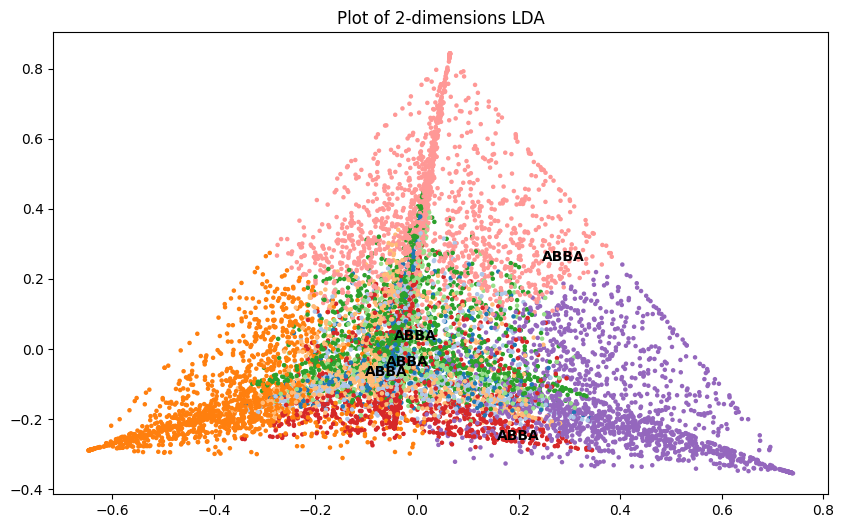

In [73]:
colormap = np.array([
    "#1f77b4", "#aec7e8", "#ff7f0e", "#ffbb78", "#2ca02c",
    "#98df8a", "#d62728", "#ff9896", "#9467bd", "#c5b0d5",
    "#8c564b", "#c49c94", "#e377c2", "#f7b6d2", "#7f7f7f",
    "#c7c7c7", "#bcbd22", "#dbdb8d", "#17becf", "#9edae5"])

colormap = colormap[:9]


pca_model_sklearn = PCA(n_components=3)  # 2 components
pca_lda_sklearn = pca_model_sklearn.fit_transform(X_topics)
# Plot
fig, ax = plt.subplots(figsize=(10,6))

scatter=ax.scatter(pca_lda_sklearn[:, 0], pca_lda_sklearn[:, 1], s=5,color=colormap[lda_keys])
ax.set_title("Plot of 2-dimensions PCA")

    
# Loop for annotation of Westlife artist
idx=dominant_topic_df[dominant_topic_df['artist'] == 'ABBA'].index.tolist()[:5]
for i in idx:
    plt.text(pca_lda_sklearn[i][0],pca_lda_sklearn[i][1],"ABBA",size='medium',weight='semibold')
    
plt.show()


We apply PCA to see how well separation across the topic categories. We can confirm LDA model works much better than Text clustering since we see the clear separation between each topic. However, there are still overlappings inside.

In [75]:
#Plot PCA 3D
#pca_lda_sklearn,x=0,y=1,z=2,color=colormap[lda_keys],
#title='3d PCA',
#    labels={'0': 'PC 1', '1': 'PC 2', '2': 'PC 3'})
##fig.show()

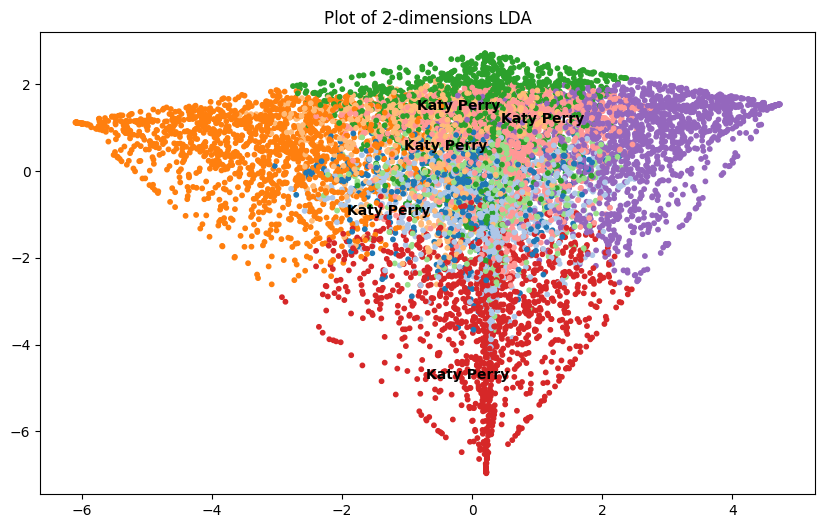

In [77]:
#Linear Discriminant Analysis
x_lda=LinearDiscriminantAnalysis(n_components=3).fit_transform(X_topics,lda_keys)

fig, ax = plt.subplots(figsize=(10,6))

scatter=ax.scatter(x_lda[:, 0], x_lda[:, 1], s=10,color=colormap[lda_keys])
ax.set_title("Plot of 2-dimensions LDA")
# Loop for annotation of Westlife artist
idx=dominant_topic_df[dominant_topic_df['artist'] == 'Katy Perry'].index.tolist()[:5]
for i in idx:
    plt.text(x_lda[i][0],x_lda[i][1],"Katy Perry",size='medium',weight='semibold')
    
plt.show()



The plot from Linear Discriminant Analysis is nearly the same as PCA. 

In [78]:
# Define helper functions
n_topics=9
def get_mean_topic_vectors(keys, two_dim_vectors):
    '''
    returns a list of centroid vectors from each predicted topic category
    '''
    mean_topic_vectors = []
    for t in range(n_topics):
        articles_in_that_topic = []
        for i in range(len(keys)):
            if keys[i] == t:
                articles_in_that_topic.append(two_dim_vectors[i])    
        
        articles_in_that_topic = np.vstack(articles_in_that_topic)
        mean_article_in_that_topic = np.mean(articles_in_that_topic, axis=0)
        mean_topic_vectors.append(mean_article_in_that_topic)
    return mean_topic_vectors

[t-SNE] Computing 451 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.008s...
[t-SNE] Computed neighbors for 10000 samples in 1.833s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.144278
[t-SNE] KL divergence after 250 iterations with early exaggeration: 75.888367
[t-SNE] KL divergence after 500 iterations: 1.602922


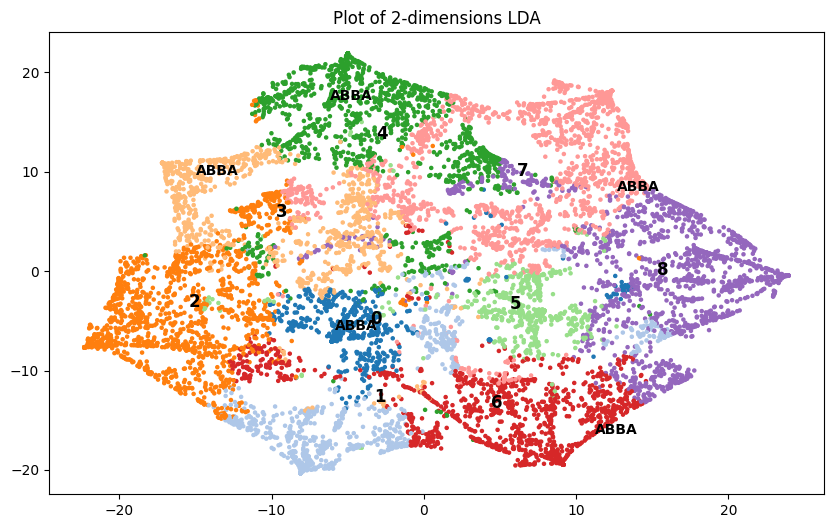

In [80]:
#TSNE 2 components
from sklearn.manifold import TSNE
tsne_lda_model = TSNE(n_components=2, perplexity=150, learning_rate=100, 
                        n_iter=500, verbose=1, random_state=0, angle=0.75)
tsne_lda_vectors = tsne_lda_model.fit_transform(X_topics)


fig, ax = plt.subplots(figsize=(10,6))

scatter=ax.scatter(tsne_lda_vectors[:, 0], tsne_lda_vectors[:, 1], s=5,color=colormap[lda_keys])

ax.set_title("Plot of 2-dimensions LDA")
#Label the topic number in the mean of each cluster.

lda_mean_topic_vectors = get_mean_topic_vectors(lda_keys, tsne_lda_vectors)
for t in range(n_topics):

    plt.text(x=lda_mean_topic_vectors[t][0],y=lda_mean_topic_vectors[t][1],s=t, color='black',size='large',weight='semibold')
    

# Loop for annotation of Westlife artist
idx=dominant_topic_df[dominant_topic_df['artist'] == 'ABBA'].index.tolist()[:5]
for i in idx:
    plt.text(tsne_lda_vectors[i][0],tsne_lda_vectors[i][1],"ABBA", color='black',size='medium',weight='semibold')
    
plt.show()


We can see how well the separation by T-SNE. Each topic was clearly separated from each other compared to other techniques that we used above. Here, I find the position of find ABBA songs and surprisingly that each song belonged to different topics.

In [ ]:
#Plot LDA 3d
#tsne_lsa_model = TSNE(n_components=3, perplexity=200, learning_rate=150, 
                        #n_iter=500, verbose=1, random_state=0, angle=0.75)
#tsne_lsa_vectors = tsne_lsa_model.fit_transform(X_topics)
#fig=px.scatter_3d(
#tsne_lsa_vectors,x=0,y=1,z=2,color=colormap[y],
#title='3d PCA',
  #  labels={'0': 'PC 1', '1': 'PC 2', '2': 'PC 3'})
# fig.show()

C:\Users\Quoc Nguyen\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.



[t-SNE] Computing 601 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.020s...
[t-SNE] Computed neighbors for 10000 samples in 4.398s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.148385
[t-SNE] KL divergence after 250 iterations with early exaggeration: 72.491951
[t-SNE] KL divergence after 500 iterations: 1.139899


C:\Users\Quoc Nguyen\anaconda3\lib\site-packages\plotly\io\_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

C:\Users\Quoc Nguyen\anaconda3\lib\site-packages\plotly\io\_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



[t-SNE] Computing 601 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.008s...
[t-SNE] Computed neighbors for 10000 samples in 2.134s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.155969
[t-SNE] KL divergence after 250 iterations with early exaggeration: 73.145081
[t-SNE] KL divergence after 500 iterations: 1.223997


C:\Users\Quoc Nguyen\AppData\Local\Temp\ipykernel_17536\948620992.py:7: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored



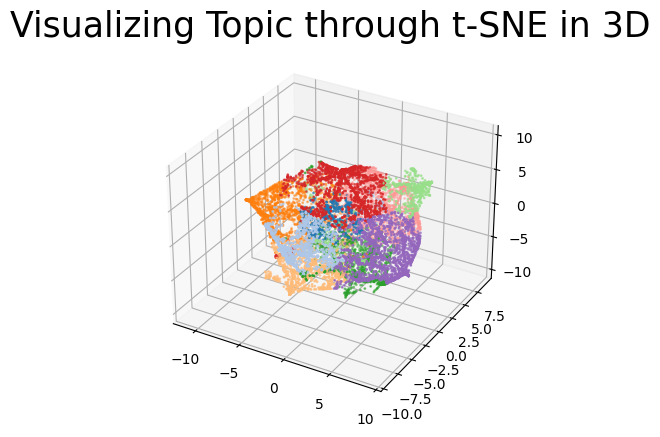

In [82]:
from mpl_toolkits.mplot3d import Axes3D
tsne_lsa_model = TSNE(n_components=3, perplexity=200, learning_rate=150, n_iter=500, verbose=1, random_state=0, angle=0.75)
tsne_lsa_vectors = tsne_lsa_model.fit_transform(X_topics)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(tsne_lsa_vectors[:, 0], tsne_lsa_vectors[:, 1],tsne_lsa_vectors[:,2], s= 1, c=colormap[lda_keys], cmap='Spectral')
plt.title('Visualizing Topic through t-SNE in 3D', fontsize=25);
plt.show()

c:\Users\Quoc Nguyen\anaconda3\envs\tensorflow\lib\site-packages\umap\distances.py:1063: NumbaDeprecationWarning:

The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.

c:\Users\Quoc Nguyen\anaconda3\envs\tensorflow\lib\site-packages\umap\distances.py:1071: NumbaDeprecationWarning:

The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.

c:\Users\Quoc Nguyen\anaconda3\envs\tensorflow\lib\site-packages\umap\distances.py:1086: Numba

Duration: 53.36468768119812 seconds


c:\Users\Quoc Nguyen\anaconda3\envs\tensorflow\lib\site-packages\matplotlib\collections.py:1080: UserWarning:

Collection without array used. Make sure to specify the values to be colormapped via the `c` argument.



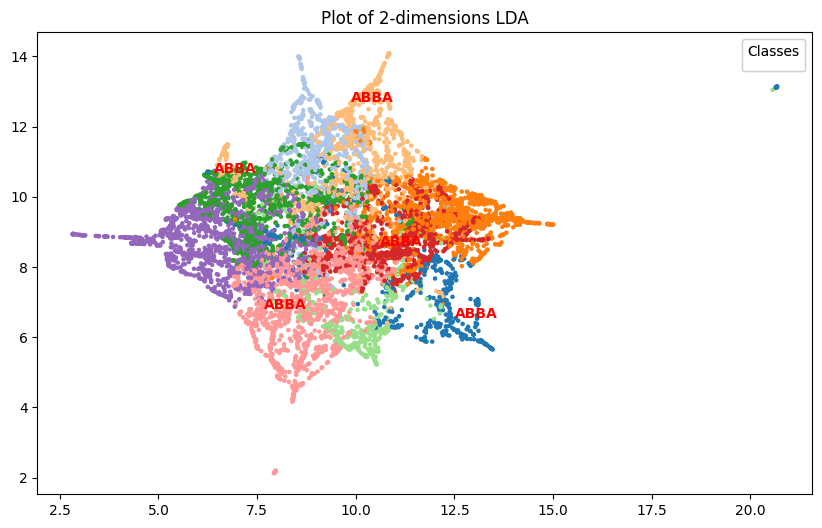

In [83]:
import umap.umap_ as umap
start = time.time()
reducer = umap.UMAP(random_state=42,n_components=3)
umap = reducer.fit_transform(X_topics)
print('Duration: {} seconds'.format(time.time() - start))
#plt.scatter(x=embedding[:,0], y=embedding[:,1],s=2, color=colormap[lda_keys])

#Plot
fig, ax = plt.subplots(figsize=(10,6))

scatter=ax.scatter(umap[:, 0], umap[:, 1], s=5,color=colormap[lda_keys])
legend1 = ax.legend(*scatter.legend_elements(), title="Classes")
ax.add_artist(legend1)
ax.set_title("Plot of 2-dimensions LDA")

# Loop for annotation of Westlife artist
idx=dominant_topic_df[dominant_topic_df['artist'] == 'ABBA'].index.tolist()[:5]
for i in idx:
    plt.text(umap[i][0],umap[i][1],"ABBA", color='red', weight='semibold')
    
plt.show()

We can see the separation between each topic by UMAP is not good as T-SNE but it still work better than other techniques.

In [ ]:
fig=px.scatter_3d(
umap,x=0,y=1,z=2,color=colormap[lda_keys],
title='3d PCA',
    labels={'0': 'PC 1', '1': 'PC 2', '2': 'PC 3'})
fig.show()

C:\Users\Quoc Nguyen\anaconda3\lib\site-packages\plotly\io\_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

C:\Users\Quoc Nguyen\anaconda3\lib\site-packages\plotly\io\_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



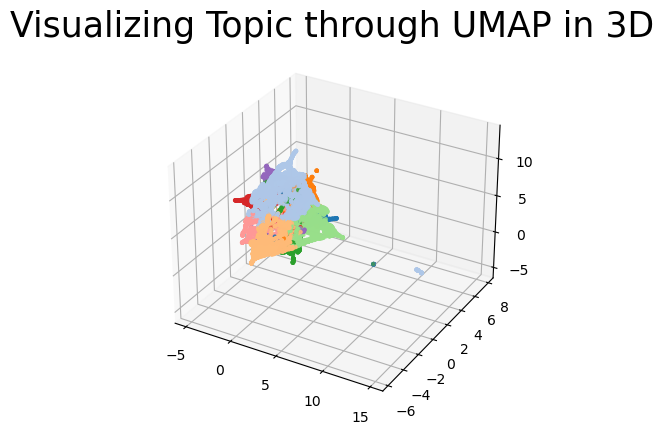

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(umap[:, 0], umap[:, 1],umap[:,2], s= 5, c=colormap[lda_keys], cmap='Spectral')
plt.title('Visualizing Topic through UMAP in 3D', fontsize=25);
plt.show()

# Conclusion

In this project, we apply to technique to find the type of each song. The first method is text clustering. However, the clustering technique did not work well on our music dataset when there were many overlappings and we can not define any differences between each group.

After that, we apply LDA Topic modeling to find the dominant topic of each song. There are two libraries to support LDA method in Python. The results from Topic modeling technique were much better than the result from text clustering. Especially, we can see the very good separation of each topic in LDA by T-SNE or UMAP.

In conclusion, we can say that topic modeling works better than text clustering in finding the similar topics based on the lyric of each song. 